# Bibliothèques

In [45]:

# Bibliothèques


import sys
import pytz # Pour retablir les dates au bon time zone
import datetime # Pour la manipulation des dates

import numpy as np # Pour la manipulation des tableaux ndarray
import pandas as pd # Pour la manipulationd des données DataFrame
import seaborn as sns # Pour la visualisation des données
import matplotlib.pyplot as plt # Pour la visualisation
%matplotlib inline
#from windrose import WindroseAxes # Pour la visualisation des données méteo

from io import StringIO # Pour la lectue des données
from numpy import concatenate # Pour la concatenation de tableau ndarray
from pandas import concat # Pour la concatenation de DataFrame

from statsmodels.graphics.tsaplots import plot_acf


from sklearn.model_selection import train_test_split # Pour faire le split des données
from sklearn.metrics import mean_squared_error, mean_absolute_error # Pour évaluer les modèles
from sklearn.ensemble import RandomForestRegressor


# Data

In [46]:

PWD="~/private/data/"

meteo_train = pd.read_csv(PWD+"meteo_train.csv", sep = ";")
conso_train = pd.read_csv(PWD+"Conso_train_new_var.csv", sep = ";")
meteo_prev = pd.read_csv(PWD+"meteo_prev.csv", sep = ";")


On met les bons noms

In [47]:


meteo_train.rename(columns = {"Date UTC" : "date", "T¬∞ (C)" :"temperature", "P (hPa)": "pression", "HR (%)" : "humidite_relative",
                                      "P.ros√©e (¬∞C)" : "point_rose","Visi (km)": "visibilite", "Vt. moy. (km/h)": "vent_moyen",
                                      "Vt. raf. (km/h)": "vent_rafale", "Vt. dir (¬∞)": "vent_direction","RR 3h (mm)": "pluie_3h", "Neige (cm)": "neige", 
                                      "Nebul. (octats)" : "nebulosite"}, inplace =True)

meteo_prev.rename(columns = {"Date UTC" : "date", "T¬∞ (C)" :"temperature", "P (hPa)": "pression", "HR (%)" : "humidite_relative",
                                      "P.ros√©e (¬∞C)" : "point_rose","Visi (km)": "visibilite", "Vt. moy. (km/h)": "mean_wind",
                                      "Vt. raf. (km/h)": "vent_rafale", "Vt. dir (¬∞)": "vent_direction","RR 3h (mm)": "pluie_3h", "Neige (cm)": "neige", 
                                      "Nebul. (octats)" : "nebulosite"}, inplace =True)


paris = pytz.timezone('Europe/Paris')

meteo_train["date"] = meteo_train["date"].str.replace("h", ":")
meteo_train["date"] = pd.to_datetime(meteo_train["date"], dayfirst = True, format = "%d/%m/%y %H:%M")
meteo_train.set_index("date", inplace = True)

meteo_prev["date"] = meteo_prev["date"].str.replace("h", ":")
meteo_prev["date"] = pd.to_datetime(meteo_prev["date"], dayfirst = True, format = "%d/%m/%y %H:%M")
meteo_prev.set_index("date", inplace = True)


conso_train["date"] = pd.to_datetime(conso_train["date"])
conso_train.set_index("date", inplace = True)
conso_train.index = conso_train.index.tz_localize(pytz.utc).tz_convert(paris)


In [48]:
# Suppression des doublons
meteo_train = meteo_train.reset_index().drop_duplicates(subset = "date").set_index("date")
meteo_train.describe()

,temperature,pression,humidite_relative,point_rose,visibilite,vent_moyen,vent_rafale,vent_direction,pluie_3h,neige,nebulosite
count,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2856.000000,2853.000000,2856.000000,2584.000000,969.0,2511.000000
mean,12.358368,1016.821218,81.296919,9.034209,19.281793,17.607125,31.239101,202.286415,0.410217,0.0,6.412983
std,4.552644,9.368261,12.846094,4.508788,13.870415,10.181637,17.185314,95.898680,1.485661,0.0,2.147243
min,-0.700000,976.400000,29.000000,-2.800000,0.000000,0.000000,3.704000,0.000000,0.000000,0.0,0.000000
25%,9.300000,1012.575000,72.750000,5.700000,10.000000,9.260000,18.520000,150.000000,0.000000,0.0,6.000000
50%,12.300000,1018.400000,84.000000,9.500000,16.000000,16.668000,29.632000,220.000000,0.000000,0.0,7.000000
75%,15.300000,1023.200000,92.000000,12.300000,25.000000,24.076000,42.596000,270.000000,0.000000,0.0,8.000000
max,32.100000,1037.700000,100.000000,19.200000,60.000000,66.672000,105.564000,360.000000,18.000000,0.0,8.000000


In [49]:


# Preprocessing
meteo_train_2015 = meteo_train["2015"]
meteo_train_2016 = meteo_train["2016"]

conso_train_2015 = conso_train["2015"]
conso_train_2016 = conso_train["2016"]




meteo_train_2015_with_one = meteo_train_2015.append(meteo_train_2016.iloc[0, :])

meteo_train_2015_resampled = meteo_train_2015_with_one.resample("H").interpolate().iloc[1:-1]

print("2015 lenght match ?", len(meteo_train_2015_resampled) == len(conso_train_2015))





meteo_train_2016_resampled = meteo_train_2016.resample("H").interpolate()

date_29_02_2016 = meteo_train_2016_resampled["2016-02-29"].index

meteo_train_2016_resampled.drop(date_29_02_2016, inplace=True)

conso_train_2016_adjusted = conso_train_2016.iloc[:-3]

print("2016 lenght match ?", len(meteo_train_2016_resampled) == len(conso_train_2016_adjusted))

mask_meteo = meteo_train_2016_resampled["2016-02-21":"2016-02-28"].index
mask_conso = conso_train_2016_adjusted["2016-02-21":"2016-02-28"].index

meteo_train_2016_resampled.drop(mask_meteo, inplace=True)
conso_train_2016_adjusted.drop(mask_conso, inplace=True)


meteo_train_resampled = pd.concat([meteo_train_2015_resampled, meteo_train_2016_resampled])

meteo_train_resampled.drop("neige", axis = 1, inplace=True)

print(meteo_train_resampled.info())

conso_train_resampled = pd.concat([conso_train_2015, conso_train_2016_adjusted])

print(conso_train_resampled.info())

2015 lenght match ? True
2016 lenght match ? True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8565 entries, 2015-09-13 01:00:00 to 2016-09-12 21:00:00
Data columns (total 10 columns):
temperature          8565 non-null float64
pression             8565 non-null float64
humidite_relative    8565 non-null float64
point_rose           8565 non-null float64
visibilite           8565 non-null float64
vent_moyen           8565 non-null float64
vent_rafale          8565 non-null float64
vent_direction       8565 non-null float64
pluie_3h             8565 non-null float64
nebulosite           8565 non-null float64
dtypes: float64(10)
memory usage: 736.1 KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8565 entries, 2015-09-13 00:59:59+02:00 to 2016-09-12 21:00:00+02:00
Data columns (total 4 columns):
puissance         8565 non-null float64
Jours             8565 non-null object
Vac_sco_ou_pas    8565 non-null int64
Ferie_ou_pas      8565 non-null int64
dtypes: float64(1), 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
#conso_train.head(5)
conso_train_1=pd.get_dummies(conso_train_resampled,['Jours']).copy().drop('puissance',axis=1)
conso_train=conso_train_resampled['puissance'].copy()


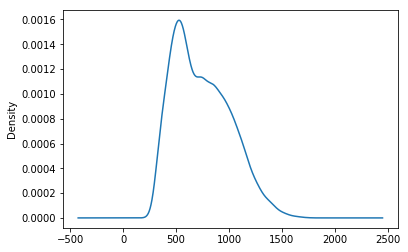

In [51]:
# La distibution des puissances n'est pas normales
(conso_train).plot.kde()

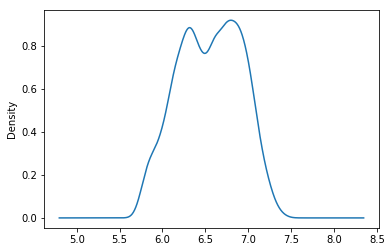

In [8]:
# Normalisons la un peu avec un log
np.log(conso_train).plot.kde()
conso_train=np.log(conso_train)

In [9]:

# Concaténation des données
meteo_train=np.c_[conso_train_1,meteo_train_resampled]
# Imputer
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import Imputer
#num_pipeline=Pipeline([
#    ('imputer',Imputer(strategy="mean"))
#])
#meteo_train=num_pipeline.fit_transform(meteo_train)

In [10]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
dataset = pd.concat([pd.DataFrame(meteo_train).reset_index(drop=True), pd.DataFrame(conso_train).reset_index(drop=True)], axis = 1)

values = dataset.values

#scaler = MinMaxScaler(feature_range=(0, 1))
# Début pipeline
#from sklearn.pipeline import Pipeline
#from sklearn.prepocessing import StandardScaler


# Fin pipeline
#scaler = StandardScaler(with_mean=True, with_std=False)

#scaled = scaler.fit_transform(values[:, :-1])

#scaled = np.c_[scaled, values[:, -1]]
scaled=values
reframed = series_to_supervised(scaled, 2, 1)


print(reframed.shape)

(8563, 60)


In [12]:
reframed.head(5)

,var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),...,var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t)
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.433333,...,1006.400000,83.000000,9.500000,40.0,11.112000,16.668000,120.000000,0.000000,8.000000,6.100693
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.366667,...,1005.833333,82.666667,9.433333,40.0,12.346667,18.520000,123.333333,0.444444,7.666667,5.902178
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.300000,...,1005.266667,82.333333,9.366667,40.0,13.581333,20.372000,126.666667,0.888889,7.333333,5.831882
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.300000,...,1004.700000,82.000000,9.300000,40.0,14.816000,22.224000,130.000000,1.333333,7.000000,5.864578
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.300000,...,1004.100000,81.333333,9.800000,40.0,16.050667,25.310667,133.333333,1.777778,7.000000,5.926481


# Nous commençons une modélisation par parties

Partie 1

In [13]:
# Filtre pour la modélisation par partie [0,500]
X=reframed.loc[reframed['var20(t)']<=np.log(500),:].copy()
#X=reframed.loc[(reframed['var20(t)']>500) & (reframed['var20(t)']<=700),:].copy()
#X=reframed.loc[reframed['var20(t)']<6.5,:].copy()

#X=reframed
Y=X['var20(t)'].copy()
X=X.drop(['var20(t)'],axis=1).copy()
#


In [14]:


#from sklearn.decomposition import PCA

#pca=PCA(n_components=0.99)
#X_reduced=pca.fit_transform(X)
X_reduced=X

In [15]:
X_reduced.shape

(1808, 59)

In [16]:
# Split Train/Test

X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y, train_size = 0.9, shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, shuffle = True)


#X_train, X_test, y_train, y_test = train_test_split(meteo_train, conso_train, train_size = 0.85, random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.9, random_state=42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)


# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#X_train = scaler.fit_transform(X_train)
#X_val=scaler.transform(X_val)


(1301, 59) (1301,) (181, 59) (181,) (326, 59) (326,)


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
# Models

# Prédicteur 0: Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbrt=GradientBoostingRegressor(max_depth=None,n_estimators=250,learning_rate=0.5)
gbrt.fit(X_train, y_train)
y_test_pred_0 = gbrt.predict(X_val)

print('Gradient Boosting',mean_absolute_error(np.exp(y_test_pred_0),np.exp(y_val)))

# Prédicteur 1: Foret
forest_reg = RandomForestRegressor(n_estimators=90,random_state=42)

forest_reg.fit(X_train, y_train)
y_test_pred_1 = forest_reg.predict(X_val)

print('Forêt aléatoire: ',mean_absolute_error(np.exp(y_test_pred_1),np.exp(y_val)))


# Predicteur 2: Extremely Randomized Trees
from sklearn.ensemble import ExtraTreesRegressor
extra=ExtraTreesRegressor(n_estimators=200,random_state=42)
extra.fit(X_train, y_train)
y_test_pred_2 = extra.predict(X_val)

print('Extra Trees: ',mean_absolute_error(np.exp(y_test_pred_2),np.exp(y_val)))

# Predicteur 3: Adaboost
#from sklearn.ensemble import AdaBoostRegressor
#ada_reg=AdaBoostRegressor(
#     base_estimator=RandomForestRegressor(n_estimators=90,random_state=42), n_estimators=100
#    ,learning_rate=0.75
#)

#ada_reg.fit(X_train, y_train)
#y_test_pred_3 = ada_reg.predict(X_val)

#print('AdaBoost: ',mean_absolute_error(np.exp(y_test_pred_3),np.exp(y_val)))



Gradient Boosting 24.609963130349602
Forêt aléatoire:  19.48141292179287
Extra Trees:  19.8565428191982


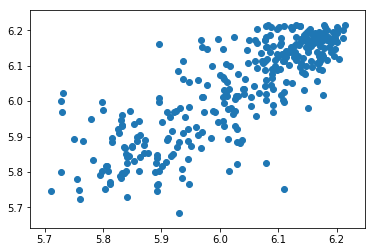

In [18]:
plt.scatter(y_test_pred_0, y_val)
plt.show()

Partie 2

In [19]:
# Filtre pour la modélisation par partie [500,700]
X=reframed.loc[(reframed['var20(t)']>np.log(500))&(reframed['var20(t)']<=np.log(700)),:].copy()

Y=X['var20(t)'].copy()
X=X.drop(['var20(t)'],axis=1).copy()



In [20]:


#from sklearn.decomposition import PCA

#pca=PCA(n_components=0.99)
#X_reduced=pca.fit_transform(X)
X_reduced=X
X_reduced.shape

(2368, 59)

In [21]:
# Split Train/Test

X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y, train_size = 0.9, shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, shuffle = True)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)



(1704, 59) (1704,) (237, 59) (237,) (427, 59) (427,)


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [22]:
# Models

# Prédicteur 0: Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbrt_1=GradientBoostingRegressor(max_depth=None,n_estimators=250,learning_rate=0.5)
gbrt_1.fit(X_train, y_train)
y_test_pred_0 = gbrt_1.predict(X_val)

print('Gradient Boosting',mean_absolute_error(np.exp(y_test_pred_0),np.exp(y_val)))

# Prédicteur 1: Foret
forest_reg_1= RandomForestRegressor(n_estimators=90,random_state=42)

forest_reg_1.fit(X_train, y_train)
y_test_pred_1 = forest_reg_1.predict(X_val)

print('Forêt aléatoire: ',mean_absolute_error(np.exp(y_test_pred_1),np.exp(y_val)))


# Predicteur 2: Extremely Randomized Trees
from sklearn.ensemble import ExtraTreesRegressor
extra_1=ExtraTreesRegressor(n_estimators=200,random_state=42)
extra_1.fit(X_train, y_train)
y_test_pred_2 = extra_1.predict(X_val)

print('Extra Trees: ',mean_absolute_error(np.exp(y_test_pred_2),np.exp(y_val)))

# Predicteur 3: Adaboost
#from sklearn.ensemble import AdaBoostRegressor
#ada_reg=AdaBoostRegressor(
#     base_estimator=RandomForestRegressor(n_estimators=90,random_state=42), n_estimators=100
 #   ,learning_rate=0.75
#)

#ada_reg.fit(X_train, y_train)
#y_test_pred_3 = ada_reg.predict(X_val)

#print('AdaBoost: ',mean_absolute_error(np.exp(y_test_pred_3),np.exp(y_val)))


Gradient Boosting 36.221755056160035
Forêt aléatoire:  27.26298273294507
Extra Trees:  26.904493484155278


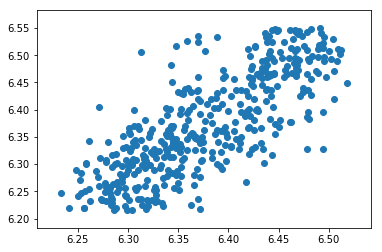

In [23]:
plt.scatter(y_test_pred_1, y_val)
plt.show()

Partie 3

In [24]:
# Filtre pour la modélisation par partie ]700,et plus]
X=reframed.loc[(reframed['var20(t)']>np.log(700)),:].copy()

Y=X['var20(t)'].copy()
X=X.drop(['var20(t)'],axis=1).copy()



#from sklearn.decomposition import PCA

#pca=PCA(n_components=0.99)
#X_reduced=pca.fit_transform(X)
X_reduced=X
X_reduced.shape


(4387, 59)

In [25]:
# Split Train/Test

X_train, X_test, y_train, y_test = train_test_split(X_reduced, Y, train_size = 0.9, shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, shuffle = True)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)


(3158, 59) (3158,) (439, 59) (439,) (790, 59) (790,)


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [26]:
# Models

# Prédicteur 0: Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor
gbrt_2=GradientBoostingRegressor(max_depth=None,n_estimators=250,learning_rate=0.5)
gbrt_2.fit(X_train, y_train)
y_test_pred_0 = gbrt_2.predict(X_val)

print('Gradient Boosting',mean_absolute_error(np.exp(y_test_pred_0),np.exp(y_val)))

# Prédicteur 1: Foret
forest_reg_2 = RandomForestRegressor(n_estimators=90,random_state=42)

forest_reg_2.fit(X_train, y_train)
y_test_pred_1 = forest_reg_2.predict(X_val)

print('Forêt aléatoire: ',mean_absolute_error(np.exp(y_test_pred_1),np.exp(y_val)))


# Predicteur 2: Extremely Randomized Trees
from sklearn.ensemble import ExtraTreesRegressor
extra_2=ExtraTreesRegressor(n_estimators=200,random_state=42)
extra_2.fit(X_train, y_train)
y_test_pred_2 = extra_2.predict(X_val)

print('Extra Trees: ',mean_absolute_error(np.exp(y_test_pred_2),np.exp(y_val)))

# Predicteur 3: Adaboost
#from sklearn.ensemble import AdaBoostRegressor
#ada_reg=AdaBoostRegressor(
#     base_estimator=RandomForestRegressor(n_estimators=90,random_state=42), n_estimators=100
 #   ,learning_rate=0.75
#)

#ada_reg.fit(X_train, y_train)
#y_test_pred_3 = ada_reg.predict(X_val)

#print('AdaBoost: ',mean_absolute_error(np.exp(y_test_pred_3),np.exp(y_val)))

Gradient Boosting 58.20377057888683
Forêt aléatoire:  44.63831754299584
Extra Trees:  46.360140533918184


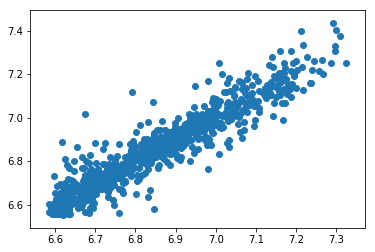

In [27]:
plt.scatter(y_test_pred_1, y_val)
plt.show()

# Classif sur l'ensemble des données

In [28]:

X=reframed.copy()
X['classe']=0
X['classe'][(X['var20(t)']>np.log(500))&(X['var20(t)']<=np.log(700))]=1
X['classe'][(X['var20(t)']>np.log(700))]=2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [29]:
X['classe'].unique()

array([0, 1, 2])

In [30]:
Y=X['classe'].copy()
Y1=X['var20(t)'].copy()
X=X.drop(['var20(t)','classe'],axis=1)

In [31]:
# Split Train/Test

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.9, shuffle = True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.8, shuffle = True)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)


(6164, 59) (6164,) (857, 59) (857,) (1542, 59) (1542,)


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [32]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(penalty='l1',class_weight='balanced')

log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_val)

In [33]:
from sklearn.metrics import accuracy_score

print('Accuracy: ',accuracy_score(y_test_pred, y_val)*100,'%')


Accuracy:  85.73281452658884 %


# Fonction predict global

In [34]:
# Pour une nouvelle valeur on prédit d'abord la classe
#La classe devient une nouvelle variable

X_val['classe_predite']=log_reg.predict(X_val)

In [35]:
# On regroupe selon la classe prédite pour acheminer 
#au bon algo

Xval_0=X_val.loc[X_val['classe_predite']==0,:]
Xval_1=X_val.loc[X_val['classe_predite']==1,:]
Xval_2=X_val.loc[X_val['classe_predite']==2,:]

In [36]:
#On supprime la variable classe prédite pour 
# avoir la bonne dimension
Xval_0=Xval_0.drop(['classe_predite'],axis=1)
Xval_1=Xval_1.drop(['classe_predite'],axis=1)
Xval_2=Xval_2.drop(['classe_predite'],axis=1)

In [37]:
# Pour chaque classe on passe la fonction predict du 
# meilleur algo pour cette classe
y_test_pred0= forest_reg.predict(Xval_0)
y_test_pred1= forest_reg_1.predict(Xval_1)
y_test_pred2= forest_reg_2.predict(Xval_2)

In [38]:
mean_absolute_error(np.exp(y_test_pred0),np.exp(Y1[Xval_0.index]))

25.275306552046896

In [39]:
mean_absolute_error(np.exp(y_test_pred1),np.exp(Y1[Xval_1.index]))

30.273407622555297

In [40]:
mean_absolute_error(np.exp(y_test_pred2),np.exp(Y1[Xval_2.index]))

36.64575287898798

In [41]:
#On concatene les prévisions
pred=np.ndarray.tolist(np.exp(y_test_pred0))+np.ndarray.tolist(np.exp(y_test_pred1))+np.ndarray.tolist(np.exp(y_test_pred2))

In [42]:
# On concatene les vraies valeurs
vrai=np.ndarray.tolist(np.exp(Y1[Xval_0.index]).values)+np.ndarray.tolist(np.exp(Y1[Xval_1.index]).values)+np.ndarray.tolist(np.exp(Y1[Xval_2.index]).values)

In [43]:
# On calcule la MAE globale
mean_absolute_error(pred,vrai)

32.378276583549166

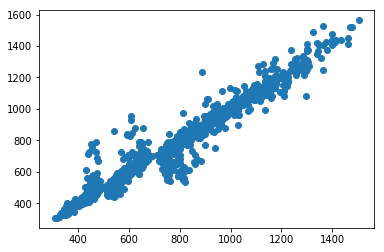

In [44]:
# On a dès lors un meilleur nuage de points
# qui ressemble plus à la première bissectrice
plt.scatter(pred, vrai)
plt.show()